In [126]:
import jax
import jax.numpy as jnp
import jax_cosmo as jc
from functools import partial

from jaxpm.painting import cic_paint, cic_paint_dx
from jaxpm.pm import linear_field, lpt, make_diffrax_ode
from jaxpm.distributed import uniform_particles
from diffrax import (
    ConstantStepSize,
    LeapfrogMidpoint,
    ODETerm,
    SaveAt,
    diffeqsolve,
    Dopri5,
    PIDController,
    TqdmProgressMeter,
    RecursiveCheckpointAdjoint,
    BacksolveAdjoint,
    ImplicitAdjoint,
    DirectAdjoint,
)

In [127]:
mesh_shape = [128, 128, 128]
box_size = [512.0, 512.0, 512.0]
snapshots = jnp.array([0.2, 0.5, 1.0])

omega_c = 0.25
sigma8 = 0.8
cosmo = jc.Planck15(Omega_c=omega_c, sigma8=sigma8)


@jax.jit
def run_lpt(cosmo):
    # Create a small function to generate the matter power spectrum
    k = jnp.logspace(-4, 1, 128)
    pk = jc.power.linear_matter_power(cosmo, k)
    pk_fn = lambda x: jnp.interp(x.reshape([-1]), k, pk).reshape(x.shape)

    # Create initial conditions
    initial_conditions = linear_field(
        mesh_shape, box_size, pk_fn, seed=jax.random.PRNGKey(0)
    )

    # Initial displacement
    cosmo._workspace = {}
    dx, p, _ = lpt(cosmo, initial_conditions, a=0.1, order=1)

    return dx, p


dx, p = run_lpt(cosmo)

In [134]:
@jax.jit
def run_nbody(cosmo, dx, p):
    # Evolve the simulation forward
    ode_fn = ODETerm(make_diffrax_ode(cosmo, mesh_shape, paint_absolute_pos=False))
    solver = Dopri5()

    stepsize_controller = PIDController(rtol=1e-10, atol=1e-10)
    res = diffeqsolve(
        ode_fn,
        solver,
        t0=0.1,
        t1=1.0,
        dt0=0.01,
        y0=jnp.stack([dx, p], axis=0),
        args=cosmo,
        saveat=SaveAt(ts=snapshots),
        stepsize_controller=stepsize_controller,
        progress_meter=TqdmProgressMeter(refresh_steps=2),
        adjoint=RecursiveCheckpointAdjoint(checkpoints=200),
    )

    ode_solutions = [sol[0] for sol in res.ys]
    return ode_solutions, res.stats

In [135]:
ode_solutions, solver_stats = run_nbody(cosmo, dx, p)

E1211 14:31:48.120229  114496 pjrt_stream_executor_client.cc:3085] Execution of replica 0 failed: INTERNAL: CustomCall failed: CpuCallback error: Traceback (most recent call last):
  File "/home/wassim/micromamba/envs/jax/lib/python3.10/runpy.py", line 196, in _run_module_as_main
  File "/home/wassim/micromamba/envs/jax/lib/python3.10/runpy.py", line 86, in _run_code
  File "/home/wassim/micromamba/envs/jax/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
  File "/home/wassim/micromamba/envs/jax/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance
  File "/home/wassim/micromamba/envs/jax/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start
  File "/home/wassim/micromamba/envs/jax/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start
  File "/home/wassim/micromamba/envs/jax/lib/python3.10/asyncio/base_events.py", line 600, in run_forever
  File "/home/wassim/micromamba/envs/jax/l

XlaRuntimeError: INTERNAL: CustomCall failed: CpuCallback error: Traceback (most recent call last):
  File "/home/wassim/micromamba/envs/jax/lib/python3.10/runpy.py", line 196, in _run_module_as_main
  File "/home/wassim/micromamba/envs/jax/lib/python3.10/runpy.py", line 86, in _run_code
  File "/home/wassim/micromamba/envs/jax/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
  File "/home/wassim/micromamba/envs/jax/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance
  File "/home/wassim/micromamba/envs/jax/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start
  File "/home/wassim/micromamba/envs/jax/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start
  File "/home/wassim/micromamba/envs/jax/lib/python3.10/asyncio/base_events.py", line 600, in run_forever
  File "/home/wassim/micromamba/envs/jax/lib/python3.10/asyncio/base_events.py", line 1896, in _run_once
  File "/home/wassim/micromamba/envs/jax/lib/python3.10/asyncio/events.py", line 80, in _run
  File "/home/wassim/micromamba/envs/jax/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue
  File "/home/wassim/micromamba/envs/jax/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one
  File "/home/wassim/micromamba/envs/jax/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell
  File "/home/wassim/micromamba/envs/jax/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request
  File "/home/wassim/micromamba/envs/jax/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request
  File "/home/wassim/micromamba/envs/jax/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute
  File "/home/wassim/micromamba/envs/jax/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
  File "/home/wassim/micromamba/envs/jax/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell
  File "/home/wassim/micromamba/envs/jax/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell
  File "/home/wassim/micromamba/envs/jax/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner
  File "/home/wassim/micromamba/envs/jax/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async
  File "/home/wassim/micromamba/envs/jax/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes
  File "/home/wassim/micromamba/envs/jax/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
  File "/tmp/ipykernel_114496/2196089797.py", line 1, in <module>
  File "/home/wassim/micromamba/envs/jax/lib/python3.10/site-packages/jax/_src/traceback_util.py", line 180, in reraise_with_filtered_traceback
  File "/home/wassim/micromamba/envs/jax/lib/python3.10/site-packages/jax/_src/pjit.py", line 338, in cache_miss
  File "/home/wassim/micromamba/envs/jax/lib/python3.10/site-packages/jax/_src/pjit.py", line 188, in _python_pjit_helper
  File "/home/wassim/micromamba/envs/jax/lib/python3.10/site-packages/jax/_src/core.py", line 2803, in bind
  File "/home/wassim/micromamba/envs/jax/lib/python3.10/site-packages/jax/_src/core.py", line 442, in bind_with_trace
  File "/home/wassim/micromamba/envs/jax/lib/python3.10/site-packages/jax/_src/core.py", line 955, in process_primitive
  File "/home/wassim/micromamba/envs/jax/lib/python3.10/site-packages/jax/_src/pjit.py", line 1738, in _pjit_call_impl
  File "/home/wassim/micromamba/envs/jax/lib/python3.10/site-packages/jax/_src/pjit.py", line 1714, in call_impl_cache_miss
  File "/home/wassim/micromamba/envs/jax/lib/python3.10/site-packages/jax/_src/pjit.py", line 1668, in _pjit_call_impl_python
  File "/home/wassim/micromamba/envs/jax/lib/python3.10/site-packages/jax/_src/profiler.py", line 333, in wrapper
  File "/home/wassim/micromamba/envs/jax/lib/python3.10/site-packages/jax/_src/interpreters/pxla.py", line 1278, in __call__
  File "/home/wassim/micromamba/envs/jax/lib/python3.10/site-packages/jax/_src/interpreters/mlir.py", line 2767, in _wrapped_callback
KeyboardInterrupt: 

In [ ]:

from jaxpm.plotting import plot_fields_single_projection

fields = {}
for i, field in enumerate(ode_solutions):
    fields[f"field_{i}"] = cic_paint_dx(field)
plot_fields_single_projection(fields, colorbar=True)

In [123]:
import time
import jax.numpy as jnp
from diffrax import (
    ODETerm,
    Tsit5,
    diffeqsolve,
    SaveAt,
    BacksolveAdjoint,
    RecursiveCheckpointAdjoint,
    ImplicitAdjoint,
    DirectAdjoint,
)


# Define the forward ODE: dy/dt = -y
def vector_field_forward(t, y, args):
    return -y


# Define the ODE term for forward and reverse dynamics
term_forward = ODETerm(vector_field_forward)

# Initial conditions
t0 = 0.0  # Initial time
t1 = 1.0  # Final time
dt0 = 0.05  # Initial step size
y0 = jnp.array(1.0)  # Initial state


@jax.jit
def forward_pass(y0):
    # Solve forward
    sol_forward = diffeqsolve(
        term_forward,
        Tsit5(),
        t0=t0,
        t1=t1,
        dt0=dt0,
        y0=y0,
        saveat=SaveAt(ts=[t1]),  # Save only the final state
        #adjoint=RecursiveCheckpointAdjoint(checkpoints=10),
        adjoint=BacksolveAdjoint(solver=Tsit5()),
        max_steps=None
    )
    return sol_forward.ys[-1]  # Final state after forward solve


#y1 = forward_pass(y0)
dy0 = jax.grad(forward_pass)(y0 + 1)

print(f"State at t={t1} after forward solve: {y1} and its gradient: {dy0}")

State at t=1.0 after forward solve: 0.36787939071655273 and its gradient: 0.3678794503211975


In [124]:

dy0 = jax.grad(forward_pass)(y0 + 16)
print(f"State at t={t1} after forward solve: {y1} and its gradient: {dy0}")

State at t=1.0 after forward solve: 0.36787939071655273 and its gradient: 0.3678794503211975


100.00%|██████████| [00:17<00:00,  5.79%/s]


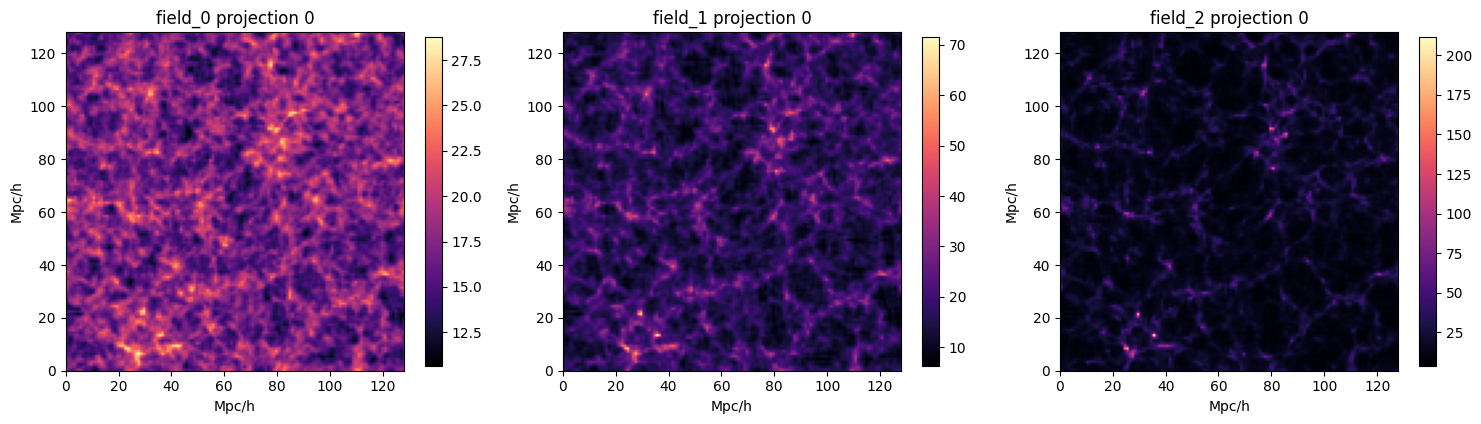

In [32]:
import jax.numpy as jnp
from diffrax import (
    ODETerm,
    Tsit5,
    ConstantStepSize,
    diffeqsolve,
    SaveAt,
    Dopri5,
    RecursiveCheckpointAdjoint,
    ImplicitAdjoint,
    DirectAdjoint,
    BacksolveAdjoint,
)

vector_field = lambda t, y, args: -y
term = ODETerm(vector_field)
solver = Tsit5()
stepsize_controller = ConstantStepSize()

t0 = 0
dt0 = 0.05
t1 = 1
y0 = jnp.array(1.0)
args = None

tprev = t0
tnext = t0 + dt0
y = y0


@jax.jit
def solve_fn(y0, solver):
    print(f"JITTING")
    sol = diffeqsolve(
        term,
        solver,
        t0=0,
        t1=1,
        dt0=0.05,
        y0=y0,
        saveat=SaveAt(ts=[0.2, 0.5, 1.0]),
        stepsize_controller=ConstantStepSize(),
        # adjoint=RecursiveCheckpointAdjoint(checkpoints=150),
        adjoint=DirectAdjoint(),
    )

    return sol.ys, sol

In [33]:
y, sol = solve_fn(y0 + 1, Dopri5())
y, sol.stats

JITTING


(Array([1.6374624 , 1.2130632 , 0.73576075], dtype=float32),
 {'max_steps': Array(4096, dtype=int32, weak_type=True),
  'num_accepted_steps': Array(20, dtype=int32, weak_type=True),
  'num_rejected_steps': Array(0, dtype=int32, weak_type=True),
  'num_steps': Array(20, dtype=int32, weak_type=True)})

In [34]:
y, sol = jax.jacrev(solve_fn, has_aux=True)(y0, Dopri5())
y, sol.stats

(Array([0.81873006, 0.6065314 , 0.36787963], dtype=float32, weak_type=True),
 {'max_steps': Array(4096, dtype=int32, weak_type=True),
  'num_accepted_steps': Array(20, dtype=int32, weak_type=True),
  'num_rejected_steps': Array(0, dtype=int32, weak_type=True),
  'num_steps': Array(20, dtype=int32, weak_type=True)})

In [36]:
import jax.numpy as jnp
from diffrax import ODETerm, Tsit5, ConstantStepSize, diffeqsolve, SaveAt

# Define the vector field
vector_field = lambda t, y, args: -y
term = ODETerm(vector_field)

# Define solver and parameters
solver = Tsit5()
stepsize_controller = ConstantStepSize()
t0 = 0
dt0 = 0.05
t1 = 1
y0 = jnp.array(1.0)

# Solve the equation
sol = diffeqsolve(
    term,
    solver,
    t0=t0,
    t1=t1,
    dt0=dt0,
    y0=y0,
    saveat=SaveAt(ts=[0.2, 0.5, 1.0]),  # Save at specific times
    stepsize_controller=stepsize_controller,
)


# Analytical solution
def analytical_solution(t):
    return y0 * jnp.exp(-t)


# Time points and numerical solution
times = sol.ts
numerical_sol = sol.ys

# Compare with analytical solution
analytical_sol = analytical_solution(times)
error = jnp.abs(numerical_sol - analytical_sol)

# Print results
print("Time points:", times)
print("Numerical solution:", numerical_sol)
print("Analytical solution:", analytical_sol)
print("Error:", error)

Time points: [0.2 0.5 1. ]
Numerical solution: [0.8187307 0.6065306 0.3678794]
Analytical solution: [0.8187308  0.60653067 0.36787948]
Error: [5.9604645e-08 5.9604645e-08 8.9406967e-08]


In [35]:
sol.ts

Array([1.], dtype=float32)